![enron stock price](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/EnronStockPriceAugust2000toJanuary2001.svg/567px-EnronStockPriceAugust2000toJanuary2001.svg.png)

In [1]:
import re
import pandas as pd
import altair as alt
import raphtory as rty
from email.utils import parsedate_to_datetime, parsedate
from datetime import timezone, datetime
from time import mktime

In [2]:
csv = pd.read_csv('emails.csv')#.sample(10000)
emails = csv['message']

In [3]:
def extract_cc_list(text):
    cc_cut = text.split("Cc: ")
    
    if len(cc_cut) > 1:
        cc_section = cc_cut[1].split(":")[0]
        cc_emails = re.findall(r'\S+@\S+', cc_section)
        return list(map(lambda email: email.split('@')[0], cc_emails))
    else:
        return 

def extract_bcc_list(text):
    bcc_cut = text.split("Bcc: ")

    if len(bcc_cut) > 1:
        bcc_section = bcc_cut[1].split(":")[0]
        bcc_emails = re.findall(r'\S+@\S+', bcc_section)
        return list(map(lambda email: email.split('@')[0], bcc_emails))
    else:
        return

extract_sender = lambda text: text.split("From: ")[1].split("@")[0]
extract_recipient = lambda text: text.split("To: ")[1].split("@")[0]
extract_date = lambda text: text.split("Date: ")[1].split("\n")[0]

enron = pd.DataFrame()
enron['src'] = emails.apply(extract_sender)
enron['dst'] = emails.apply(extract_recipient)
enron['time'] = emails.apply(extract_date)
enron['type'] = 'direct'
enron['message'] = emails

enron_cc = enron.loc[:, ['src', 'time', 'message']]
enron_cc['dst'] = emails.apply(extract_cc_list)     
enron_cc = enron_cc.explode('dst').dropna()
enron_cc['type'] = 'cc'

enron_bcc = enron.loc[:, ['src', 'time', 'message']]
enron_bcc['dst'] = emails.apply(extract_bcc_list)     
enron_bcc = enron_bcc.explode('dst').dropna()
enron_bcc['type'] = 'bcc'

enron = pd.concat([enron, enron_cc, enron_bcc])
enron

,src,dst,time,message,type
0,phillip.allen,tim.belden,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",Message-ID: <18782981.1075855378110.JavaMail.e...,direct
1,phillip.allen,john.lavorato,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Message-ID: <15464986.1075855378456.JavaMail.e...,direct
2,phillip.allen,leah.arsdall,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Message-ID: <24216240.1075855687451.JavaMail.e...,direct
3,phillip.allen,randall.gay,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",Message-ID: <13505866.1075863688222.JavaMail.e...,direct
4,phillip.allen,greg.piper,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Message-ID: <30922949.1075863688243.JavaMail.e...,direct
...,...,...,...,...,...
517323,john.zufferli,kimberly.hillis,"Wed, 13 Jun 2001 07:19:27 -0700 (PDT)",Message-ID: <15205398.1075842036502.JavaMail.e...,bcc
517335,john.zufferli,rob.milnthorp,"Thu, 24 Jan 2002 14:00:42 -0800 (PST)",Message-ID: <20351161.1075842028492.JavaMail.e...,bcc
517352,john.zufferli,rob.milnthorp,"Fri, 18 Jan 2002 06:52:25 -0800 (PST)",Message-ID: <12099366.1075842028905.JavaMail.e...,bcc
517371,john.zufferli,jzufferli,"Mon, 7 Jan 2002 13:01:08 -0800 (PST)",Message-ID: <537849.1075842029343.JavaMail.eva...,bcc


In [4]:
enron[enron['dst'].str.contains('fastow')]

,src,dst,time,message,type
38085,enronsato,andrew.fastow,"Mon, 22 Oct 2001 04:57:09 -0700 (PDT)",Message-ID: <7772166.1075863357115.JavaMail.ev...,direct
38432,paula.rieker,andrew.fastow,"Wed, 17 Oct 2001 06:30:48 -0700 (PDT)",Message-ID: <22428221.1075863381137.JavaMail.e...,direct
38953,bgrizzle,s..fastow,"Tue, 27 Mar 2001 07:20:07 -0800 (PST)",Message-ID: <4584343.1075863364743.JavaMail.ev...,direct
38982,marion.sczykutowicz,andrew.fastow,"Tue, 7 Aug 2001 12:30:56 -0700 (PDT)",Message-ID: <19929392.1075863365565.JavaMail.e...,direct
39257,sharron.westbrook,andrew.fastow,"Wed, 12 Sep 2001 08:18:59 -0700 (PDT)",Message-ID: <9688892.1075863372608.JavaMail.ev...,direct
...,...,...,...,...,...
502048,maxine.levingston,andrew.fastow,"Fri, 25 May 2001 03:07:00 -0700 (PDT)",Message-ID: <7709700.1075858050386.JavaMail.ev...,bcc
502720,ben.glisan,andrew.fastow,"Thu, 7 Dec 2000 05:05:00 -0800 (PST)",Message-ID: <32642159.1075857998517.JavaMail.e...,bcc
502840,ben.glisan,andrew.fastow,"Thu, 7 Dec 2000 05:05:00 -0800 (PST)",Message-ID: <25967097.1075858002582.JavaMail.e...,bcc
503209,maxine.levingston,andrew.fastow,"Fri, 25 May 2001 03:07:00 -0700 (PDT)",Message-ID: <14322844.1075858057649.JavaMail.e...,bcc


In [5]:
# would be cool to do this in the graph itself instead of doing it in pandas an recreating the graph:
stock_enron = enron[enron['message'].str.contains('stock')]
stock_enron

,src,dst,time,message,type
95,phillip.allen,mac.d.hargrove,"Mon, 21 Aug 2000 09:40:00 -0700 (PDT)",Message-ID: <29919154.1075855689201.JavaMail.e...,direct
381,phillip.allen,kim.bolton,"Thu, 15 Mar 2001 06:11:00 -0800 (PST)",Message-ID: <21041312.1075855725847.JavaMail.e...,direct
483,phillip.allen,mike.grigsby,"Tue, 30 Jan 2001 23:14:00 -0800 (PST)",Message-ID: <4137934.1075855727873.JavaMail.ev...,direct
543,phillip.allen,mac.d.hargrove,"Wed, 20 Dec 2000 07:51:00 -0800 (PST)",Message-ID: <23792894.1075855729213.JavaMail.e...,direct
584,phillip.allen,stephen.stock,"Tue, 31 Oct 2000 04:44:00 -0800 (PST)",Message-ID: <17616616.1075855687082.JavaMail.e...,direct
...,...,...,...,...,...
516938,mark.dupuy,derek.davies,"Wed, 30 Jan 2002 15:22:28 -0800 (PST)",Message-ID: <19394568.1075842022894.JavaMail.e...,bcc
516938,mark.dupuy,john.zufferli,"Wed, 30 Jan 2002 15:22:28 -0800 (PST)",Message-ID: <19394568.1075842022894.JavaMail.e...,bcc
516938,mark.dupuy,sandra.quon,"Wed, 30 Jan 2002 15:22:28 -0800 (PST)",Message-ID: <19394568.1075842022894.JavaMail.e...,bcc
516969,rob.milnthorp,dawn.doucet,"Mon, 28 Jan 2002 14:11:59 -0800 (PST)",Message-ID: <3631322.1075842023934.JavaMail.ev...,bcc


In [6]:
g = rty.Graph(1)
def ingest_edge(record):
    g.add_edge(record['time'], record['src'], record['dst'], {'message': record['message']}, record['type'])
enron.apply(ingest_edge, axis=1)
g = g.window(start='2000-01-01 00:00:00', end='2003-01-01 00:00:00')
g

Graph(number_of_edges=256300, number_of_vertices=52864, earliest_time=946684800000, latest_time=1041379200000)

In [7]:
g.layer('direct').num_edges(), g.layer('cc').num_edges(), g.layer('bcc').num_edges()

(84070, 88297, 83933)

In [8]:
# I'd like to be able to write something like this for two reasons:
#  1. it's cleaner
#  2. as we are providing directly an iterable to be consumed by pandas, it's probably more efficient
#  3. we are calling num_edges in rust world instead of in python 

# rolling = g.rolling('1 week')
# n_edges = pd.DataFrame(index=rolling.time_index())
# for layer in ['direct', 'cc', 'bcc']:
#     n_edges[layer] = rolling.layer(layer).num_edges()

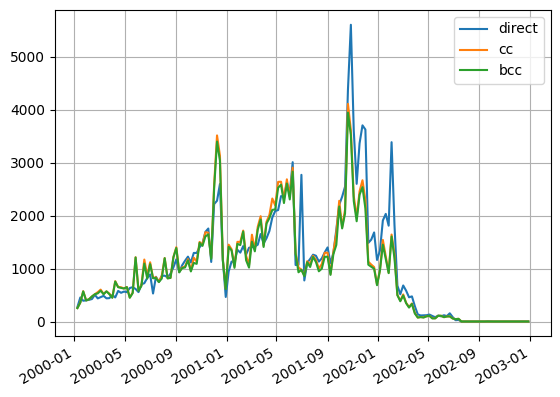

In [9]:
rolling = g.rolling('1 week')
time_index = [datetime.fromtimestamp(w.end() / 1000) for w in rolling]

n_edges = pd.DataFrame()
for layer in ['direct', 'cc', 'bcc']:
    n_edges[layer] = [w.layer(layer).num_edges() for w in rolling]
n_edges.index = time_index
n_edges.plot.line(grid=True);

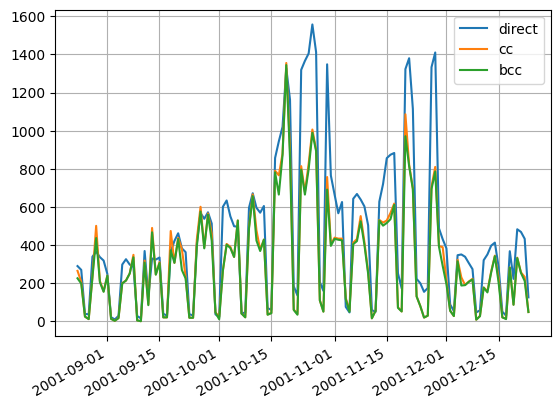

In [10]:
rolling = g.window('2001-08-23 00:00:00', '2001-12-23 00:00:00').rolling('1 day')
time_index = [datetime.fromtimestamp(w.end() / 1000) for w in rolling]

n_edges = pd.DataFrame()
for layer in ['direct', 'cc', 'bcc']:
    n_edges[layer] = [w.layer(layer).num_edges() for w in rolling]
n_edges.index = time_index
n_edges.plot.line(grid=True);

In [12]:
def get_top_n_vertices(g, n):
    vertices = pd.DataFrame()
    vertices['vertex'] = g.vertices()
    vertices['in_degree'] = vertices['vertex'].apply(lambda vertex: vertex.in_degree())
    top_vertices = vertices.sort_values('in_degree', ascending=False).head(n)['vertex'].to_list()
    return top_vertices

In [13]:
events = [
    ['2001-10-22', 'share price collapse'],
    # ['2001-11-08', 'overstated profits'],
    ['2001-12-02', 'bankruptcy'],
]
events = pd.DataFrame(events, columns=['time', 'event'])
event_rules = alt.Chart(events).mark_rule(color='gray').encode(
    x='time:T'
)
labels = alt.Chart(events).mark_text(dx=3, dy=-120, color='black', align='left').encode(
    x='time:T',
    text='event'
)
event_chart = alt.layer(event_rules, labels)

w = g.window('2001-09-01 00:00:00', '2002-01-27 00:00:00')

selection = alt.selection_multi(fields=['person'], bind='legend')

top_nodes = get_top_n_vertices(w, 15) + [w.vertex('andrew.fastow')]


def in_degree_for_vertex(vertex):
    rolling = vertex.rolling(step='1 day', window='1 week')
    t_index = [datetime.fromtimestamp(w.end() / 1000) for w in rolling]
    in_degree = [w.in_degree() for w in rolling]
    return pd.Series(in_degree, index=t_index)

def in_degree_for_layer(vertices, layer):
    in_degree = pd.DataFrame()
    for vertex in vertices:
        in_degree[vertex.name()] = in_degree_for_vertex(vertex.layer(layer))
    top_names = [vertex.name() for vertex in vertices]
    source = pd.melt(in_degree.reset_index(names='time'), id_vars=['time'], value_vars=top_names, var_name='person', value_name='in_degree')
    chart = alt.Chart(source).mark_line().encode(
        x="time:T",
        y="in_degree:Q",
        color="person",
        tooltip=['person', 'in_degree'],
        opacity=alt.condition(selection, alt.value(1.0), alt.value(0.2))
    ).properties(
        width=700,
        title=f'{layer} emails'
    ).add_selection(
        selection
    )
    return alt.layer(chart, event_chart)

alt.vconcat(
    in_degree_for_layer(top_nodes, 'direct'),
    in_degree_for_layer(top_nodes, 'cc'),
    in_degree_for_layer(top_nodes, 'bcc')
)

alt.VConcatChart(...)

Relevant nodes in the network:
- kenneth.lay: Kenneth Lay (CEO)
- andrew.fastow: Andrew Fastow (CFO)
- louise.kitchen: Louise Kitchen (Managing Director)
- j.kaminski: Vincent Kaminski (Managing Director for Research, raised strong objections to the financial practices of Andrew Fastow)
- a..shankman: Jeffrey Adam Shankman (Head of the global markets division, charged with White Collard Crime)
- michelle.cash: Michelle Cash (Assistant General Counsel)